In [1]:
import torch
import numpy as np
from torch import einsum
from tqdm.notebook import tqdm
import seaborn as sns
from transformer_lens import HookedTransformer
from datasets import load_dataset
from einops import einsum
import pandas as pd

In [2]:
def ablate_mlp_hook(value, hook):
    return torch.zeros_like(value)

model = HookedTransformer.from_pretrained("tiny-stories-1M", device="cuda")
valid_dataset = load_dataset('roneneldan/TinyStories', split='validation', streaming=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)

layer_to_ablate = 0
original_losses = []
ablation_losses = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(valid_dataloader)):
        tokens = model.to_tokens(batch["text"])
        
        original_loss = model(tokens, return_type="loss")
        original_losses.append(original_loss.item())

        ablated_loss = model.run_with_hooks(
                tokens, 
                return_type="loss", 
                fwd_hooks=[(
                    f"blocks.{layer_to_ablate}.mlp.hook_post", 
                    ablate_mlp_hook
                    )]
                )
        ablation_losses.append(ablated_loss.item())

print(f"Original model loss: {np.mean(original_losses):.6f}")
print(f"Ablated MLP layer {layer_to_ablate} loss: {np.mean(ablation_losses):.6f}")

Using pad_token, but it is not set yet.


Loaded pretrained model tiny-stories-1M into HookedTransformer


0it [00:00, ?it/s]

Original model loss: 5.843791
Ablated MLP layer 0 loss: 5.737778


In [2]:
def ablate_mlp_hook(value, hook):
    return torch.zeros_like(value)

def get_log_probs(logits, tokens):
    log_probs = logits.log_softmax(dim=-1)
    log_probs_for_tokens = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)
    return log_probs_for_tokens

valid_dataset = load_dataset('roneneldan/TinyStories', split='validation', streaming=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)

model = HookedTransformer.from_pretrained("tiny-stories-1M", device="cuda")

layer_to_ablate = 0
ablation_losses = []
original_losses = []
embedding_losses = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(valid_dataloader)):
        data = batch["text"]
        tokens = model.to_tokens(data)

        # Embedding layer only
        embedded = model.embed.W_E[tokens, :]
        unembed = einsum(embedded, model.unembed.W_U, 'batch pos d_model, d_model d_vocab -> \
            batch pos d_vocab') + model.unembed.b_U
        embedding_losses.append(-get_log_probs(unembed, tokens).mean().item())
        
        # Full model
        loss = model(tokens, return_type="loss").item()
        original_losses.append(loss)

        # Ablated MLP layer
        ablated_loss = model.run_with_hooks(
                tokens, 
                return_type="loss", 
                fwd_hooks=[(
                    f"blocks.{layer_to_ablate}.mlp.hook_post", 
                    ablate_mlp_hook
                    )]
                )
        ablation_losses.append(ablated_loss.item())
        
print(f"Embedding only loss: {np.mean(embedding_losses):.6f}")
print(f"Full model loss: {np.mean(original_losses):.6f}")
print(f"Ablated MLP layer {layer_to_ablate} loss: {np.mean(ablation_losses):.6f}")

Using pad_token, but it is not set yet.


Loaded pretrained model tiny-stories-1M into HookedTransformer


0it [00:00, ?it/s]

Embedding only loss: 5.990667
Full model loss: 5.843791
Ablated MLP layer 0 loss: 5.737778


In [10]:
dfs = [pd.DataFrame({"loss": ablation_losses, "name": "Ablated"}), 
        pd.DataFrame({"loss": original_losses, "name": "FullModel"}),
        pd.DataFrame({"loss": embedding_losses, "name": "EmbeddingOnly"})]
df = pd.concat(dfs)
df.groupby("name").agg(["mean", "std"])

loss          
                   mean       std
name                             
Ablated        5.737778  1.032263
EmbeddingOnly  5.990667  0.170675
FullModel      5.843791  0.456182

<Axes: xlabel='loss', ylabel='Probability'>

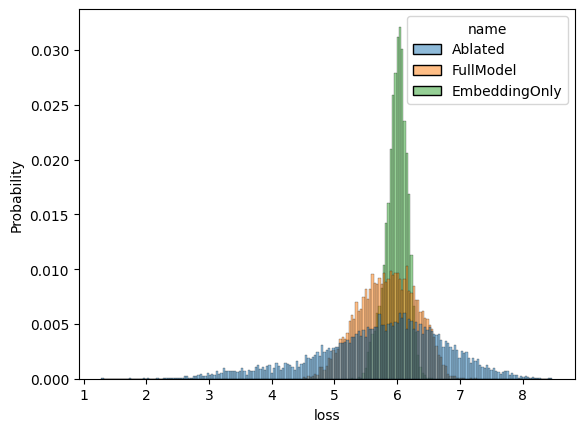

In [11]:
sns.histplot(df, x="loss", hue="name", stat="probability")